<a href="https://colab.research.google.com/github/nahumsa/qhack21/blob/master/Meta_VQE_Pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from IPython.display import clear_output
! pip install pennylane
clear_output()

# Can meta-VQE beat barren Plateaus?

# 1) Meta-VQE

For this demo I will be using the XXZ spin chain just like the original [Meta-VQE paper](https://arxiv.org/abs/2009.13545) and is based on the [demo](https://github.com/AlbaCL/qhack21/blob/main/Meta-VQE.ipynb) by Alba Cervera-Lierta written using [Tequila](https://github.com/aspuru-guzik-group/tequila).

The XXZ spin chain has the following Hamiltonian:

$$
\mathcal{H} = \sum_{i=1}^N \big( X_i X_{i+1} + Y_i Y_{i+1} + \Delta Z_i Z_{i+1} \big) + \eta \sum_{i=1}^N Z_i
$$



In [3]:
import numpy as np
import pennylane as qml
from tqdm.notebook import tqdm

In [4]:
def hamiltonian_XXZ(n_qubits: int, delta: float, eta: float) -> qml.Hamiltonian:
    """ Creates the XXZ hamiltonian, which is given by:

    $$
    \mathcal{H} = \sum_{i=1}^N \big( X_i X_{i+1} + Y_i Y_{i+1} 
    + \Delta Z_i Z_{i+1} \big) + \eta \sum_{i=1}^N Z_i
    $$

    Args:
        n_qubits(int): number of spins in the chain.
        delta(float): delta parameter.
        eta(float): eta parameter.
    """
    hamiltonian = []
    coeffs = []
    
    # Periodic Boundary Conditions
    for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
        hamiltonian.append(op(n_qubits-1)@op(0))
        if op != qml.PauliZ :
            coeffs.append(1.)
        else:
            coeffs.append(delta)
    
    hamiltonian.append(qml.PauliZ(n_qubits-1))
    coeffs.append(eta)

    for qubits in range(n_qubits - 1):
        for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
            
            hamiltonian.append(op(qubits)@op(qubits+1))
            
            if op != qml.PauliZ :
                coeffs.append(1.)
            else:
                coeffs.append(delta)
        
        hamiltonian.append(qml.PauliZ(qubits))
        coeffs.append(eta)

    H = qml.Hamiltonian(coeffs, hamiltonian, simplify=True)
    return H

def hamiltonian_to_matrix(H: qml.Hamiltonian) -> np.array:
    """ Converts a pennylane Hamiltonian object into a matrix.

    Args:
        H(qml.Hamiltonian): Hamiltonian.

    Output:
        np.array: Outputs the matrix representation of the Hamiltonian.
    """
    mat = np.zeros((2**n_qubits, 2**n_qubits), np.complex128)
    for coef, op in zip(*H.terms):
        mat += coef*qml.utils.expand(op.matrix, op.wires, n_qubits)
    return mat

def exact_gs(H: qml.Hamiltonian) -> float:
    """ Calculates the Ground State energy of the Hamiltonian.

    Args:
        H(qml.Hamiltonian): Hamiltonian.

    Output:
        float: outputs the ground state energy of the Hamiltonian.
    """
    matrix = hamiltonian_to_matrix(H)
    energies = np.linalg.eigvals(matrix)
    return np.real(min(energies))

In [ ]:
n_qubits = 2
delta = 2.
eta = 2.
H = hamiltonian_XXZ(n_qubits, delta, eta)
print(H)

## 1.1) Creating the ansatz

In order to create an ansatz it is needed to do an encoding of the Hamiltonian parameter. For this case I choose to do a linear encoding of the parameter $\Delta$ of the XXZ Hamiltonian:

$$
S(\Delta, \theta) = R_Z ( \theta_0 \ \Delta + \theta_1) R_Y ( \theta_2 \ \Delta + \theta_3)
$$

For the processing layer, U, we have that:

$$
U(\theta) = R_Z ( \theta_0 ) R_Y ( \theta_1)
$$

In [7]:
def variational_ansatz(params: np.array, delta: float , wires: qml.wires, H=None):
    """ Variational ansatz with linear encoding.


    """
    n_layers = params.shape[0]
    n_qubits = params.shape[1]
    for L in range(n_layers):
        # Encoding Layer
        if L % 2 == 0:
            for qubit in range(n_qubits):
                qml.RZ(params[L][qubit][0] * delta + params[L][qubit][1], wires=qubit)
                qml.RY(params[L][qubit][2] * delta + params[L][qubit][3], wires=qubit)
            
            for ent in range(0, n_qubits - 1, 2):
                qml.CNOT(wires= [ent, ent+1])
        
        # Processing Layer
        else:
            for qubit in range(n_qubits):
                qml.RZ(params[L][qubit][0] , wires=qubit)
                qml.RY(params[L][qubit][2] , wires=qubit)
            
            for ent in range(0, n_qubits - 1, 2):
                qml.CNOT(wires= [ent, ent+1])

# 1.2) Defining the cost function

The idea for the loss function is to minimize the energy value over all training points $H(\lambda_i)$, thus I choose the same cost function as the original paper that is the sum over all training data:

$$
\mathcal{L}_{\mathrm{LOSS}} = \sum_{i=1}^M \langle \psi_i | H (\lambda_i) | \psi_i \rangle
$$

In [28]:
def ExpvalH(H: qml.Hamiltonian, device: qml.device):
    coeffs, observables = H.terms
    qnodes = qml.map(
            variational_ansatz, observables, device
            )
    cost = qml.dot(coeffs, qnodes)
    return cost

def m_vqe_cost(train_deltas: np.array, dev: qml.device , params: np.array):
    # cost function value
    c = 0.
    n_qubits = dev.num_wires

    for delta in train_deltas:
        H = hamiltonian_XXZ(n_qubits, delta, eta)
        cost = ExpvalH(H, dev)
        c += cost(params, delta=delta)
    
    return c

In [ ]:
# Creating training data
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)
train_deltas = np.random.uniform(low=-1, high=1, size=5)

# Hyperparameters
eta = 0.75
n_layers = 4 # One encoding and one processing
L = 2*n_layers

# initializing parameters
params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(L, n_qubits, 4))

# Training Parameters
epochs = 10
optimizer = qml.AdagradOptimizer()

from functools import partial

# Applyies train_deltas for the Meta-VQE cost function
cost_fn = partial(m_vqe_cost, train_deltas, dev)

pbar = tqdm(range(epochs), desc='Energy', leave=True)

for i in pbar:
    params, val = optimizer.step_and_cost(cost_fn, params)
    pbar.set_description(f"Loss: {val:.3f}")

params_mvqe = params.copy()

## 1.3) Testing the trained model

In [ ]:
# Creating test data
test_deltas = np.random.uniform(low=-1, high=1, size=50)
test_energies = np.zeros_like(test_deltas)
exact_energies = np.zeros_like(test_deltas)

n_qubits = dev.num_wires

for i, delta in tqdm(enumerate(test_deltas)):
    H = hamiltonian_XXZ(n_qubits, delta, eta)
    cost = ExpvalH(H, dev)
    test_energies[i] = cost(params_mvqe, delta=delta)
    exact_energies[i] = exact_gs(H)

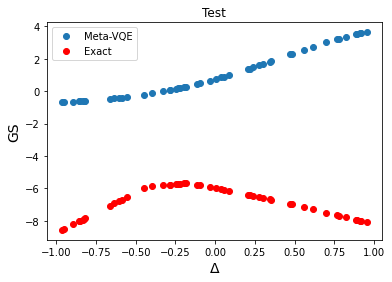

In [167]:
import matplotlib.pyplot as plt

plt.plot(test_deltas, test_energies, 'o', label='Meta-VQE')
plt.plot(test_deltas, exact_energies, 'ro', label='Exact')
plt.title("Test")
plt.xlabel("$\Delta$", fontsize=14)
plt.ylabel("GS", fontsize=14)
plt.legend()
plt.show()

## 2) Comparing the gradients after training and plain VQE

The next step is to compare the weight initialization using Meta-VQE and random initialization for the problem.

## Meta-VQE

In [ ]:
from functools import partial

# Creating training data
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)
train_deltas = np.random.uniform(low=-1.1, high=1.1, size=5)

# Hyperparameters
eta = 0.75
n_layers = 1 # One encoding and one processing
L = 2*n_layers

# initializing parameters
params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(L, n_qubits, 4))

# Training Parameters
epochs = 50
optimizer = qml.AdagradOptimizer()

v_gradient = []
samples = 100

for _ in tqdm(range(samples)):
    # Applyies train_deltas for the Meta-VQE cost function
    cost_fn = partial(m_vqe_cost, train_deltas, dev)
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(L, n_qubits, 4))
    optimizer = qml.AdagradOptimizer()

    # Optimization step
    for i in range(epochs):
        params, val = optimizer.step_and_cost(cost_fn, params)
    # Copy optimal parameters
    params_mvqe = params.copy()

    H = hamiltonian_XXZ(n_qubits, delta=0., eta=eta)
    # Compute the gradient
    qcircuit = qml.QNode(variational_ansatz, dev)
    cost_fn = ExpvalH(H, dev)
    grad = qml.grad(cost_fn, argnum=0)
    gradient = grad(params_mvqe, delta=0.)
    v_gradient.append(gradient[0][0][-1])

In [12]:
# 2 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: 0.0644 +/- 2.2986


In [14]:
# 3 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: -0.1154 +/- 0.7320


In [10]:
# 4 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: -0.2379 +/- 0.7413


## VQE

In [49]:
# Creating training data
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

L = 2
samples = 100
v_gradient = []
for _ in tqdm(range(samples)):
    H = hamiltonian_XXZ(n_qubits, delta=0., eta=eta)
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(L, n_qubits, 4))
    # Compute the gradient
    qcircuit = qml.QNode(variational_ansatz, dev)
    cost_fn = ExpvalH(H, dev)
    grad = qml.grad(cost_fn, argnum=0)
    gradient = grad(params, delta=0.)
    v_gradient.append(gradient[0][0][-1])

In [23]:
# 2 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: 0.1927 +/- 2.0610


In [31]:
# 3 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: -0.0350 +/- 0.7845


In [40]:
# 4 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: -0.1999 +/- 0.6010


In [50]:
# 5 qubits
var = np.var(v_gradient)
mean = np.mean(v_gradient)
print(f"mean: {mean:.4f} +/- {var:.4f}")

mean: -0.0266 +/- 0.5715


# Results

Text(0.5, 1.0, 'Gradients')

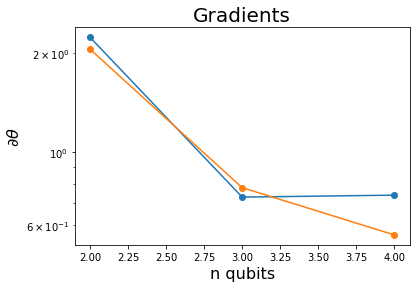

In [54]:
import matplotlib.pyplot as plt 

var_mvqe = [2.2386, 0.73, 0.74]
var_vqe = [2.06, 0.78, 0.56]

plt.plot(range(2,5), var_mvqe, '-o')
plt.plot(range(2,5), var_vqe, '-o')
plt.yscale('log')
plt.xlabel('n qubits', fontsize=16)
plt.ylabel(r'$\partial\theta$', fontsize=16)
plt.title('Gradients', fontsize=20)